# Assessing repression strategies against epidemic outbreak

Author: Daniele Proverbio  
        LCSB, University of Luxembourg       
        01/04/2020

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd #manipolazione dati

from scipy import stats #statistica
from scipy.optimize import curve_fit

In [689]:
def base_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    
    S, E, I, R= [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T


def delay_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma, rho1, tau = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        if len(E)<tau:
            next_S = S[-1] - (beta*S[-1]*I[-1])*dt
            next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt    
        else:
            next_S = S[-1] - (rho1*beta*S[-1]*I[-1])*dt
            next_E = E[-1] + (rho1*beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T



def seir_model_with_soc_dist(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma, rho1 = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        if len(E)<100:
            next_S = S[-1] - (beta*S[-1]*I[-1])*dt
            next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt    
        else:
            next_S = S[-1] - (rho1*beta*S[-1]*I[-1])*dt
            next_E = E[-1] + (rho1*beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T


def identify_and_remove_asymptomatic_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0, P_0 = init_vals
    Q_0 = 0
    S, E, I, R, P, Q = [S_0], [E_0], [I_0], [R_0], [P_0], [Q_0]
    alpha, beta, gamma, mu, rho, x, y = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (rho*beta*S[-1]*I[-1] + mu*S[-1])*dt
        
        if len(E)<100:
            next_E = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1])*dt
            next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
            next_Q = Q[-1]
        else: 
            next_E = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1] - y*x*0.33*E[-1])*dt  #3 days to get reliable results from PCR
            next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
            next_Q = Q[-1] + (y*x*0.33*E[-1])*dt
                           
        next_R = R[-1] + (gamma*I[-1])*dt
        next_P = P[-1] + (mu*S[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        P.append(next_P)
    return np.stack([S, E, I, R, P]).T

def protection_seir_model(init_vals, params, t):     #protection
    S_0, E_0, I_0, R_0 = init_vals
    P_0 = 0
    S, E, I, R, P = [S_0], [E_0], [I_0], [R_0], [P_0]
    alpha, beta, gamma, mu = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        if len(E)<100:
            next_S = S[-1] - (beta*S[-1]*I[-1])*dt
            next_P = P[-1]
        else:
            next_S = S[-1] - (beta*S[-1]*I[-1] + mu*S[-1])*dt
            next_P = P[-1] + (mu*S[-1])*dt
            
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        P.append(next_P)
    return np.stack([S, E, I, R, P]).T


def hard_lockdown_seir_model(init_vals, params, t):     # sudden decrease of susceptible fraction
    S_0, E_0, I_0, R_0 = init_vals
    P_0 = 0
    S, E, I, R, P = [S_0], [E_0], [I_0], [R_0], [P_0]
    alpha, beta, gamma, mu = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        if len(E)<100:
            next_S = S[-1] - (beta*S[-1]*I[-1])*dt
            next_P = P[-1]
        if len(E)>=100 and len(E)<120:                  # two days 
            next_S = S[-1] - (beta*S[-1]*I[-1] + mu*S[-1])*dt
            next_P = P[-1] + (mu*S[-1])*dt
        if len(E)>=120:
            next_S = S[-1] - (beta*S[-1]*I[-1])*dt
            next_P = P[-1]
            
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        P.append(next_P)
    return np.stack([S, E, I, R, P]).T


## Testing the delay in setting measures

In [525]:
# Define parameters
t_max = 300 #1000 to span time_to_zero better
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0 ,0    #working with fractions of population
alpha = 0.2     # incubation period 5 days
beta = 0.85     # average contact rate [beta = R0*gamma; R0 = 2.5 (Hellewell, 2020)]
gamma = 0.34    # mean infectious period = 2.9 (Kucharski,2020)
rho = 0.4         # To get exactly R=1
mu = 0.0        # removal rate
tau = 10 *10

params_delay = alpha, beta, gamma, rho, tau
results_delay = delay_seir_model(init_vals[:4], params_delay, t)

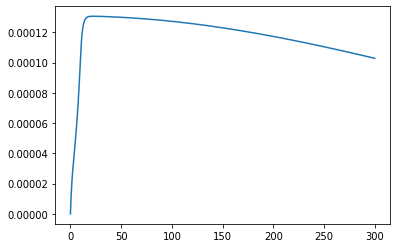

In [526]:
plt.plot(t,results_delay.T[2])

Perfect: delays might change the suppression of the curve (as noted by German Epidemiology Institute) but do not affect the qualitative sublinear behavior for R<1

## Active latents' removal

In [690]:
# Define parameters
t_max = 1000 #to span time_to_zero better
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0 ,0    #working with fractions of population
alpha = 0.2     # incubation period 5 days
beta = 0.85     # average contact rate [beta = R0*gamma; R0 = 2.5 (Hellewell, 2020)]
gamma = 0.34    # mean infectious period = 2.9 (Kucharski,2020)
rho = 1         # social distancing (to control contact rate )    #0.56 to get R_0=2.5, as many predictions do
mu = 0.0        # removal rate
ics = np.linspace(0, 1, 100)    #percentage of asymptomatic correctly identified and removed (detection accuracy)
ypsilon = np.linspace(0, 1, 100) #sensitivity of the tests to get asymptomatic (testing accuracy)

In [691]:
# considering chi
# peak maximum

maximi=np.zeros([100,100])
maximus=np.zeros(100)
maximus_total=np.zeros(100)
maximum_indices = []

starting = 600

zero_infectious_position = np.zeros(100)

for k in range(len(ics)):
    params_identify_exposed = alpha, beta, gamma, mu, rho, ics[k], 1
    results_identify_exposed = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed, t)
    maximus[k]=max(results_identify_exposed.T[2])
    maximus_total[k]=max(results_identify_exposed.T[2]+results_identify_exposed.T[1])
    
    test = results_identify_exposed.T[2,starting:]
    
    for i in range(len(test)):
        if test[i]<=0.00001 and zero_infectious_position[k] ==0:
            zero_infectious_position[k] = i + starting

In [693]:
# considering test sensitivity as standalone, then the rest

for n in range(len(ics)):
    for m in range(len(ypsilon)):
        params_identify_exposed = alpha, beta, gamma, mu, rho, ics[n], ypsilon[m]
        
    
        results_identify_exposed = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed, t)
        #maximus.append(max(results_identify_exposed.T[2]))
        maximi[n,m]=max(results_identify_exposed.T[2])
        #maximum_indices.append(np.where(results_identify_exposed.T[2]==max(results_identify_exposed.T[2])))

### Peak plots

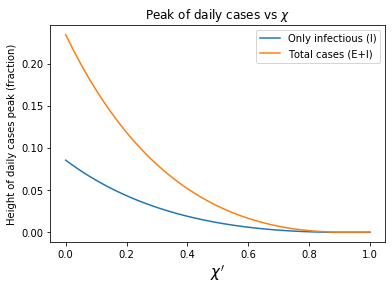

In [695]:
# considering chi (plot)

fig_chi = plt.figure()

plot(ics,maximus, label="Only infectious (I)")
plot(ics,maximus_total, label="Total cases (E+I)")

plt.title("Peak of daily cases vs $\\chi$")
xlabel("$\\chi'$",fontsize=15)
ylabel("Height of daily cases peak (fraction)")
plt.legend()

fig_chi.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/plots_covid/chi.png",bbox_inches = "tight",transparent=True)

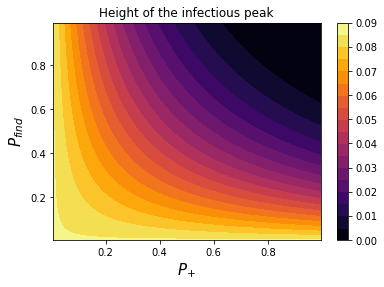

In [694]:
# considering test sensitivity as standalone, then the rest

import matplotlib.pyplot as pylt
import matplotlib.colors as mcolors

fig, ax = plt.subplots()

plt.contourf(maximi,20, cmap='inferno',extent=[0,1,0,1],origin="lower")   #other colormap:viridis
plt.colorbar()


plt.xlabel('$P_{+}$',fontsize=15) #corresponds to ypsilon
plt.ylabel('$P_{find}$',fontsize=15) #corresponds to ics
#plt.xlabel("Test accuracy")    
#plt.ylabel("Detection accuracy")    
plt.title("Height of the infectious peak")
#fig.patch.set_facecolor('xkcd:silver')

plt.show()

fig.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/plots_covid/chi_tests.png",bbox_inches = "tight",transparent=True)

In [696]:
# Precise control on plots for showing

params_identify_exposed_1 = alpha, beta, gamma, mu, rho, ics[81], ypsilon[10]
params_identify_exposed_2 = alpha, beta, gamma, mu, rho, ics[82], ypsilon[20]
params_identify_exposed_3 = alpha, beta, gamma, mu, rho, ics[81], ypsilon[30]
params_identify_exposed_4 = alpha, beta, gamma, mu, rho, ics[81], ypsilon[40]
params_identify_exposed_5 = alpha, beta, gamma, mu, rho, ics[81], ypsilon[50]
params_identify_exposed_6 = alpha, beta, gamma, mu, rho, ics[81], ypsilon[60]
params_identify_exposed_7 = alpha, beta, gamma, mu, rho, ics[81], ypsilon[70]
params_identify_exposed_8 = alpha, beta, gamma, mu, rho, ics[81], ypsilon[80]
params_identify_exposed_9 = alpha, beta, gamma, mu, rho, ics[81], ypsilon[90]


results_identify_exposed_1 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_1, t)
results_identify_exposed_2 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_2, t)
results_identify_exposed_3 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_3, t)
results_identify_exposed_4 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_4, t)
results_identify_exposed_5 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_5, t)
results_identify_exposed_6 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_6, t)
results_identify_exposed_7 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_7, t)
results_identify_exposed_8 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_8, t)
results_identify_exposed_9 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_9, t)

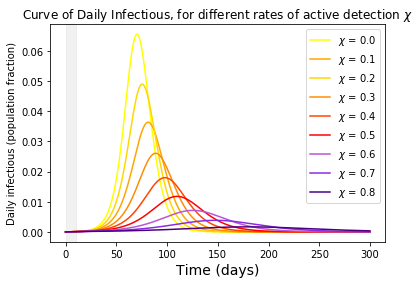

In [697]:
a, ax = plt.subplots(nrows=1, ncols=1)

plt.plot(t[:3000],results_identify_exposed_1.T[2,:3000],"yellow",label="$\\chi$ = 0.0")
plt.plot(t[:3000],results_identify_exposed_3.T[2,:3000],"orange",label="$\\chi$ = 0.1")
plt.plot(t[:3000],results_identify_exposed_2.T[2,:3000],"gold",label="$\\chi$ = 0.2")
plt.plot(t[:3000],results_identify_exposed_4.T[2,:3000],"darkorange",label="$\\chi$ = 0.3")
plt.plot(t[:3000],results_identify_exposed_5.T[2,:3000],"orangered",label="$\\chi$ = 0.4")
plt.plot(t[:3000],results_identify_exposed_6.T[2,:3000],"red",label="$\\chi$ = 0.5")
plt.plot(t[:3000],results_identify_exposed_7.T[2,:3000],"mediumorchid",label="$\\chi$ = 0.6")
plt.plot(t[:3000],results_identify_exposed_8.T[2,:3000],"blueviolet",label="$\\chi$ = 0.7")
plt.plot(t[:3000],results_identify_exposed_9.T[2,:3000],"indigo",label="$\\chi$ = 0.8")
#follow inferno colormap

plt.title("Curve of Daily Infectious, for different rates of active detection $\\chi$")
xlabel("Time (days)", fontsize=14)
plt.legend()
ax.axvspan(0, 10, alpha=0.3, color='lightgrey')

ylabel("Daily infectious (population fraction)")

a.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/plots_covid/chi_curves.png",bbox_inches = "tight",transparent=True)

### Time-to-zero plot

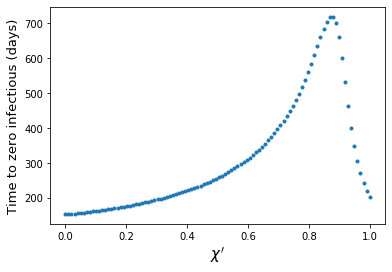

In [698]:
# considering chi (plot)

#data_zero_infectious = [1428,1555,1720,1954,2297,2838]


fig_time = plt.figure()
plot(ics,zero_infectious_position*dt,'.')

xlabel("$\\chi'$",fontsize=15)
ylabel("Time to zero infectious (days)",fontsize=13)

fig_time.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/plots_covid/chi_tests.png",bbox_inches = "tight",transparent=True)

# Only social distancing

In [500]:
# Define parameters
t_max = 1000
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0 ,0    #working with fractions of population
alpha = 0.2    # incubation period 5 days
beta = 0.85    # average contact rate [beta = R0*gamma; R0 = 3.5 (Hellewell, 2020); R0 = 3 from GEI]
gamma = 0.34   # mean infectious period = 3 following German Epidemiology Institute (GEI) [or = 2 (Peng, 2020) in Wuhan]
rho = np.linspace(0, 1, 1000)   # social distancing (to control contact rate )
rho1 = 0.4
mu = 0.0     # removal rate

In [501]:
# considering rho
# peak maximum

maximi_sd=np.zeros([1000,1000])
maximus_sd=np.zeros(1000)
maximus_total_sd=np.zeros(1000)
maximum_indices_sd = []

starting = 600

zero_infectious_position_sd = np.zeros(1000)

for k in range(len(rho)):
    params_soc_dist = alpha, beta, gamma, rho[k]     
    results_soc_dist = seir_model_with_soc_dist(init_vals[:4], params_soc_dist, t)
    maximus_sd[k]=max(results_soc_dist.T[2])
    maximus_total_sd[k]=max(results_soc_dist.T[2]+results_soc_dist.T[1])
    
    test_sd = results_soc_dist.T[2,starting:]
    
    for i in range(len(test_sd)):
        if test_sd[i]<=0.00005 and zero_infectious_position_sd[k] ==0:
            zero_infectious_position_sd[k] = i + starting

In [502]:
# Just a sample

params_soc_dist_1 = alpha, beta, gamma, rho[100]
params_soc_dist_2 = alpha, beta, gamma, rho[200]
params_soc_dist_3 = alpha, beta, gamma, rho[300]
params_soc_dist_4 = alpha, beta, gamma, rho[400]
params_soc_dist_5 = alpha, beta, gamma, rho[500]
params_soc_dist_6 = alpha, beta, gamma, rho[600]
params_soc_dist_7 = alpha, beta, gamma, rho[700]
params_soc_dist_8 = alpha, beta, gamma, rho[800]
params_soc_dist_9 = alpha, beta, gamma, rho[900]

params_soc_dist_10 = alpha, beta, gamma, 0.4


results_soc_dist_1 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_1, t)
results_soc_dist_2 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_2, t)
results_soc_dist_3 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_3, t)
results_soc_dist_4 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_4, t)
results_soc_dist_5 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_5, t)
results_soc_dist_6 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_6, t)
results_soc_dist_7 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_7, t)
results_soc_dist_8 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_8, t)
results_soc_dist_9 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_9, t)

results_soc_dist_10 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_10, t)

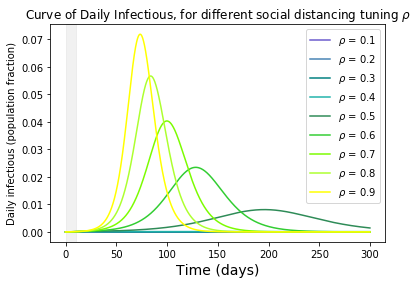

In [503]:
b, ax = plt.subplots(nrows=1, ncols=1)

stop_plot1 = 3000

plt.plot(t[:stop_plot1],results_soc_dist_1.T[2,:stop_plot1],"slateblue",label="$\\rho$ = 0.1")
plt.plot(t[:stop_plot1],results_soc_dist_3.T[2,:stop_plot1],"steelblue",label="$\\rho$ = 0.2")
plt.plot(t[:stop_plot1],results_soc_dist_2.T[2,:stop_plot1],"teal",label="$\\rho$ = 0.3")
plt.plot(t[:stop_plot1],results_soc_dist_4.T[2,:stop_plot1],"lightseagreen",label="$\\rho$ = 0.4")
plt.plot(t[:stop_plot1],results_soc_dist_5.T[2,:stop_plot1],"seagreen",label="$\\rho$ = 0.5")
plt.plot(t[:stop_plot1],results_soc_dist_6.T[2,:stop_plot1],"limegreen",label="$\\rho$ = 0.6")
plt.plot(t[:stop_plot1],results_soc_dist_7.T[2,:stop_plot1],"lawngreen",label="$\\rho$ = 0.7")
plt.plot(t[:stop_plot1],results_soc_dist_8.T[2,:stop_plot1],"greenyellow",label="$\\rho$ = 0.8")
plt.plot(t[:stop_plot1],results_soc_dist_9.T[2,:stop_plot1],"yellow",label="$\\rho$ = 0.9")
#follow viridis colormap

plt.title("Curve of Daily Infectious, for different social distancing tuning $\\rho$")
xlabel("Time (days)", fontsize=14)
plt.legend()

ax.axvspan(0, 10, alpha=0.3, color='lightgrey')

ylabel("Daily infectious (population fraction)")

b.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/plots_covid/rho_curves.png",bbox_inches = "tight",transparent=True)

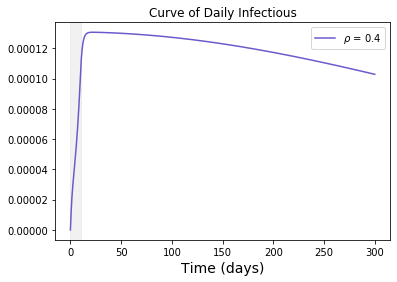

In [504]:
# check for \rho=0.4 (hence R=1)

params_soc_dist_special = alpha, beta, gamma, rho1 
results_soc_dist_special = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_special, t)


b, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(t[:stop_plot1],results_soc_dist_special.T[2,:stop_plot1],"slateblue",label="$\\rho$ = 0.4")
plt.title("Curve of Daily Infectious")
xlabel("Time (days)", fontsize=14)
plt.legend()
ax.axvspan(0, 10, alpha=0.3, color='lightgrey')

### Peak Plots

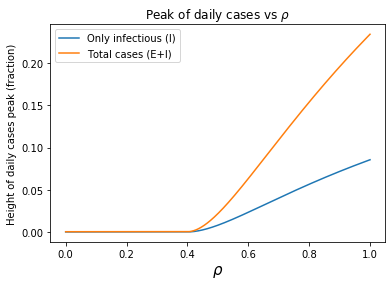

In [505]:
# considering rho (plot)

fig_rho = plt.figure()

plot(rho,maximus_sd, label="Only infectious (I)")
plot(rho,maximus_total_sd, label="Total cases (E+I)")

plt.title("Peak of daily cases vs $\\rho$")
xlabel("$\\rho$",fontsize=15)
ylabel("Height of daily cases peak (fraction)")
plt.legend()

fig_rho.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/plots_covid/rho.png",bbox_inches = "tight",transparent=True)

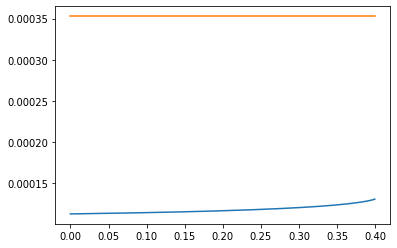

In [508]:
plot(rho[:400],maximus_sd[:400], label="Only infectious (I)")
plot(rho[:400],maximus_total_sd[:400], label="Total cases (E+I)")

### Time-to-zero plot

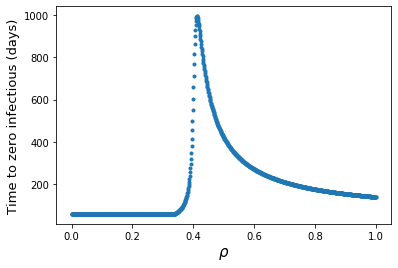

In [509]:
fig_time = plt.figure()
plot(rho,zero_infectious_position_sd*dt,'.')

xlabel("$\\rho$",fontsize=15)
ylabel("Time to zero infectious (days)",fontsize=13)

fig_time.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/plots_covid/rho_tests.png",bbox_inches = "tight",transparent=True)

# Only Active protection

In [699]:
# Define parameters
t_max = 1000
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0 ,0    #working with fractions of population
alpha = 0.2    # incubation period 5 days
beta = 0.85    # average contact rate 
gamma = 0.34   # mean infectious period = 3 following German Epidemiology Institute (GEI) [or = 2 (Peng, 2020) in Wuhan]
rho = 1   # social distancing (to control contact rate )
mu = np.linspace(0, 0.2, 100)     # removal rate

In [700]:
# considering mu
# peak maximum

maximi_pr=np.zeros([100,100])
maximus_pr=np.zeros(100)
maximus_total_pr=np.zeros(100)
maximum_indices_pr = []

starting = 600

zero_infectious_position_pr = np.zeros(100)

for k in range(len(mu)):
    params_protection = alpha, beta, gamma, mu[k]     
    results_protection = protection_seir_model(init_vals[:4], params_protection, t)
    maximus_pr[k]=max(results_protection.T[2])
    maximus_total_pr[k]=max(results_protection.T[2]+results_protection.T[1])
    
    test_pr = results_protection.T[2,starting:]
    
    for i in range(len(test_sd)):
        if test_pr[i]<=0.0000001 and zero_infectious_position_pr[k] ==0:
            zero_infectious_position_pr[k] = i + starting

### Peak plots

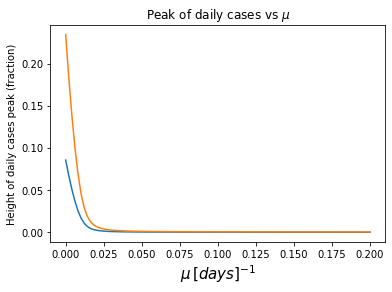

In [701]:
# considering chi (plot)

fig_mu = plt.figure()

plot(mu,maximus_pr, label="Only infectious (I)")
plot(mu,maximus_total_pr, label="Total cases (E+I)")

plt.title("Peak of daily cases vs $\\mu$")
xlabel("$\\mu \, [days]^{-1}$",fontsize=15)
ylabel("Height of daily cases peak (fraction)")
#plt.legend()

fig_mu.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/plots_covid/mu.png",bbox_inches = "tight",transparent=True)

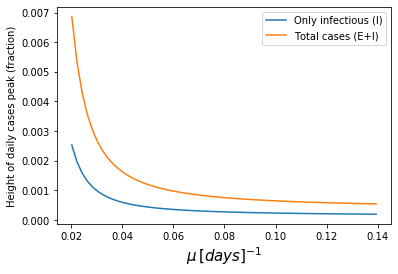

In [702]:
# considering chi (plot)

fig_mu = plt.figure()

plot(mu[10:70],maximus_pr[10:70], label="Only infectious (I)")
plot(mu[10:70],maximus_total_pr[10:70], label="Total cases (E+I)")

#plt.title("Peak of daily cases vs $\\mu$")
xlabel("$\\mu  \, [days]^{-1}$",fontsize=15)
ylabel("Height of daily cases peak (fraction)")
plt.legend()

fig_mu.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/plots_covid/mu1.png",bbox_inches = "tight",transparent=True)

In [703]:
# Just a sample

params_protection_1 = alpha, beta, gamma, mu[10] 
params_protection_2 = alpha, beta, gamma, mu[20] 
params_protection_3 = alpha, beta, gamma, mu[30] 
params_protection_4 = alpha, beta, gamma, mu[40] 
params_protection_5 = alpha, beta, gamma, mu[50] 
params_protection_6 = alpha, beta, gamma, mu[60] 
params_protection_7 = alpha, beta, gamma, mu[70] 
params_protection_8 = alpha, beta, gamma, mu[80] 
params_protection_9 = alpha, beta, gamma, mu[90] 

params_protection_15 = alpha, beta, gamma, mu[1] 
params_protection_13 = alpha, beta, gamma, mu[2] 
params_protection_10 = alpha, beta, gamma, mu[3] 
params_protection_11 = alpha, beta, gamma, mu[4] 
params_protection_12 = alpha, beta, gamma, mu[5] 
params_protection_14 = alpha, beta, gamma, mu[6] 
params_protection_16 = alpha, beta, gamma, mu[0] 


results_protection_1 = protection_seir_model(init_vals[:4], params_protection_1, t)
results_protection_2 = protection_seir_model(init_vals[:4], params_protection_2, t)
results_protection_3 = protection_seir_model(init_vals[:4], params_protection_3, t)
results_protection_4 = protection_seir_model(init_vals[:4], params_protection_4, t)
results_protection_5 = protection_seir_model(init_vals[:4], params_protection_5, t)
results_protection_6 = protection_seir_model(init_vals[:4], params_protection_6, t)
results_protection_7 = protection_seir_model(init_vals[:4], params_protection_7, t)
results_protection_8 = protection_seir_model(init_vals[:4], params_protection_8, t)
results_protection_9 = protection_seir_model(init_vals[:4], params_protection_9, t)

results_protection_10 = protection_seir_model(init_vals[:4], params_protection_10, t)
results_protection_11 = protection_seir_model(init_vals[:4], params_protection_11, t)
results_protection_12 = protection_seir_model(init_vals[:4], params_protection_12, t)
results_protection_13 = protection_seir_model(init_vals[:4], params_protection_13, t)
results_protection_14 = protection_seir_model(init_vals[:4], params_protection_14, t)
results_protection_15 = protection_seir_model(init_vals[:4], params_protection_15, t)
results_protection_16 = protection_seir_model(init_vals[:4], params_protection_16, t)

In [704]:
mu[80]

0.1616161616161616

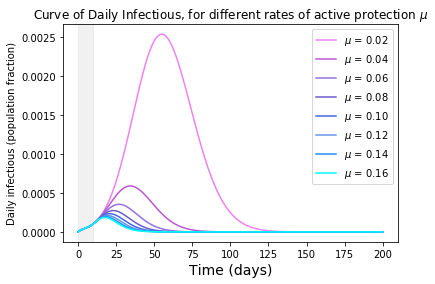

In [705]:
c, ax = plt.subplots(nrows=1, ncols=1)

stop_plot = 2000

#correct legend!
#plt.plot(t[:stop_plot],results_protection_14.T[2,:stop_plot],"plum",label="$\\mu$ = 0.01")
plt.plot(t[:stop_plot],results_protection_1.T[2,:stop_plot],"violet",label="$\\mu$ = 0.02")
plt.plot(t[:stop_plot],results_protection_2.T[2,:stop_plot],"mediumorchid",label="$\\mu$ = 0.04")
plt.plot(t[:stop_plot],results_protection_3.T[2,:stop_plot],"mediumpurple",label="$\\mu$ = 0.06")
plt.plot(t[:stop_plot],results_protection_4.T[2,:stop_plot],"slateblue",label="$\\mu$ = 0.08")
plt.plot(t[:stop_plot],results_protection_5.T[2,:stop_plot],"royalblue",label="$\\mu$ = 0.10")
plt.plot(t[:stop_plot],results_protection_6.T[2,:stop_plot],"cornflowerblue",label="$\\mu$ = 0.12")
plt.plot(t[:stop_plot],results_protection_7.T[2,:stop_plot],"dodgerblue",label="$\\mu$ = 0.14")
plt.plot(t[:stop_plot],results_protection_8.T[2,:stop_plot],"aqua",label="$\\mu$ = 0.16")
#plt.plot(t[:stop_plot],results_protection_9.T[2,:stop_plot],"aqua",label="$\\mu$ = 0.18")
#follow cool colormap

plt.title("Curve of Daily Infectious, for different rates of active protection $\\mu$")
xlabel("Time (days)", fontsize=14)
plt.legend()
ax.axvspan(0, 10, alpha=0.3, color='lightgrey')

ylabel("Daily infectious (population fraction)")

c.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/plots_covid/mu_curves.png",bbox_inches = "tight",transparent=True)

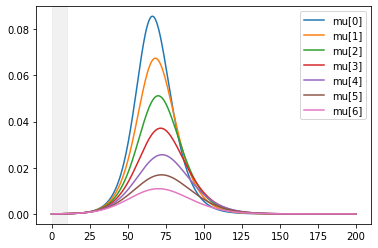

In [516]:
# zooming in
z, ax = plt.subplots(nrows=1, ncols=1)

plt.plot(t[:2000], results_protection_16.T[2,:2000],label="mu[0]")
plt.plot(t[:2000], results_protection_15.T[2,:2000],label="mu[1]")
plt.plot(t[:2000], results_protection_13.T[2,:2000],label="mu[2]")
plt.plot(t[:2000], results_protection_10.T[2,:2000],label="mu[3]")
plt.plot(t[:2000], results_protection_11.T[2,:2000],label="mu[4]")
plt.plot(t[:2000], results_protection_12.T[2,:2000],label="mu[5]")
plt.plot(t[:2000], results_protection_14.T[2,:2000],label="mu[6]")
ax.axvspan(0, 10, alpha=0.3, color='lightgrey')

plt.legend()

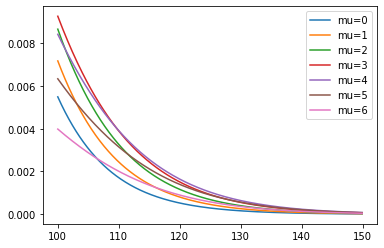

In [517]:
# zooming in the zooming in
plt.plot(t[1000:1500], results_protection_16.T[2,1000:1500],label="mu=0")
plt.plot(t[1000:1500], results_protection_15.T[2,1000:1500],label="mu=1")
plt.plot(t[1000:1500], results_protection_13.T[2,1000:1500],label="mu=2")
plt.plot(t[1000:1500], results_protection_10.T[2,1000:1500],label="mu=3")
plt.plot(t[1000:1500], results_protection_11.T[2,1000:1500],label="mu=4")
plt.plot(t[1000:1500], results_protection_12.T[2,1000:1500],label="mu=5")
plt.plot(t[1000:1500], results_protection_14.T[2,1000:1500],label="mu=6")

plt.legend()

### Time-to-zero plot

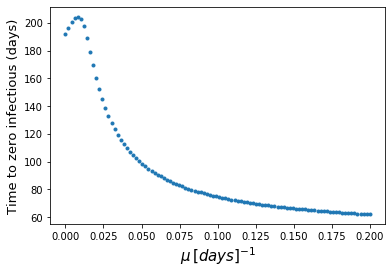

In [706]:
fig_time = plt.figure()
plot(mu,zero_infectious_position_pr*dt,'.')

xlabel("$\\mu  \, [days]^{-1}$",fontsize=15)
ylabel("Time to zero infectious (days)",fontsize=13)

fig_time.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/plots_covid/mu_tests.png",bbox_inches = "tight",transparent=True)

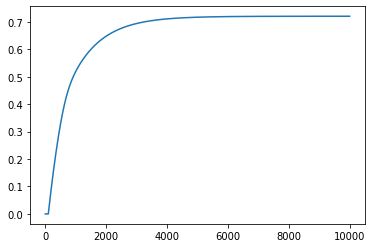

In [713]:
# cumulative protected

mu[5]

plot(results_protection_12.T[4])

### Effect of hard lockdown

In [519]:
# with high mu, but for short periods, to isolate vast fraction of the population

# Define parameters
t_max = 1000
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0 ,0    #working with fractions of population
alpha = 0.2    # incubation period 5 days
beta = 0.85    # average contact rate 
gamma = 0.34   # mean infectious period = 3 following German Epidemiology Institute (GEI) [or = 2 (Peng, 2020) in Wuhan]
rho = 1   # social distancing (to control contact rate )
mu1 = np.linspace(0.3, 1, 100)     # removal rate

In [520]:
# considering mu
# peak maximum

maximi_ld=np.zeros([100,100])
maximus_ld=np.zeros(100)
maximus_total_ld=np.zeros(100)
maximum_indices_ld = []

starting = 600

zero_infectious_position_ld = np.zeros(100)

for k in range(len(mu)):
    params_lockdown = alpha, beta, gamma, mu1[k]     
    results_lockdown = hard_lockdown_seir_model(init_vals[:4], params_lockdown, t)
    maximus_ld[k]=max(results_lockdown.T[2])
    maximus_total_ld[k]=max(results_lockdown.T[2]+results_lockdown.T[1])
    
    test_ld = results_lockdown.T[2,starting:]
    
    for i in range(len(test_sd)):
        if test_ld[i]<=0.0000001 and zero_infectious_position_ld[k] ==0:
            zero_infectious_position_ld[k] = i + starting

In [521]:
# Just a sample

params_lockdown_1 = alpha, beta, gamma, mu1[10] 
params_lockdown_2 = alpha, beta, gamma, mu1[20] 
params_lockdown_3 = alpha, beta, gamma, mu1[30] 
params_lockdown_4 = alpha, beta, gamma, mu1[40] 
params_lockdown_5 = alpha, beta, gamma, mu1[50] 
params_lockdown_6 = alpha, beta, gamma, mu1[60] 
params_lockdown_7 = alpha, beta, gamma, mu1[70] 
params_lockdown_8 = alpha, beta, gamma, mu1[80] 
params_lockdown_9 = alpha, beta, gamma, mu1[90] 


results_lockdown_1 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_1, t)
results_lockdown_2 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_2, t)
results_lockdown_3 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_3, t)
results_lockdown_4 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_4, t)
results_lockdown_5 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_5, t)
results_lockdown_6 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_6, t)
results_lockdown_7 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_7, t)
results_lockdown_8 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_8, t)
results_lockdown_9 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_9, t)

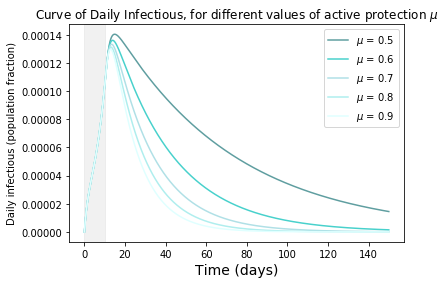

In [534]:
d, ax = plt.subplots(nrows=1, ncols=1)

stop_plot = 1500
 
#plt.plot(t[:stop_plot],results_lockdown_2.T[2,:stop_plot],"teal",label="$\\mu$ = 0.4")   #let's see if inserting or not. It's constant as predicted by the formula...
plt.plot(t[:stop_plot],results_lockdown_3.T[2,:stop_plot],"cadetblue",label="$\\mu$ = 0.5")
plt.plot(t[:stop_plot],results_lockdown_4.T[2,:stop_plot],"mediumturquoise",label="$\\mu$ = 0.6")
plt.plot(t[:stop_plot],results_lockdown_5.T[2,:stop_plot],"powderblue",label="$\\mu$ = 0.7")
plt.plot(t[:stop_plot],results_lockdown_6.T[2,:stop_plot],"paleturquoise",label="$\\mu$ = 0.8")
plt.plot(t[:stop_plot],results_lockdown_7.T[2,:stop_plot],"lightcyan",label="$\\mu$ = 0.9")
#follow cool colormap

plt.title("Curve of Daily Infectious, for different values of active protection $\\mu$")
xlabel("Time (days)", fontsize=14)
plt.legend()
ax.axvspan(0, 10, alpha=0.3, color='lightgrey')

ylabel("Daily infectious (population fraction)")

d.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/plots_covid/mu_curves1.png",bbox_inches = "tight",transparent=True)

Text(0, 0.5, 'Population fraction (protected)')

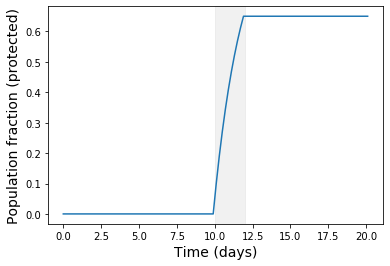

In [687]:
# Plot hard lockdown mu

mock_time = np.linspace(0,20,101)
mu_5 = []
for i in mock_time:
    if i<10:
        mu_5.append(0)
    elif i>= 10 and i <12:
        mu_5.append(0.5)
    else:
        mu_5.append(0)

e, ax = plt.subplots(nrows=1, ncols=1)
stop_plot_hard_ld = len(mock_time)*2
plt.plot(t[:stop_plot_hard_ld],results_lockdown_3.T[4,:stop_plot_hard_ld],label="Total Protected")
ax.axvspan(10, 12, alpha=0.3, color='lightgrey')
xlabel("Time (days)", fontsize=14)
ylabel("Population fraction (protected)", fontsize=14)


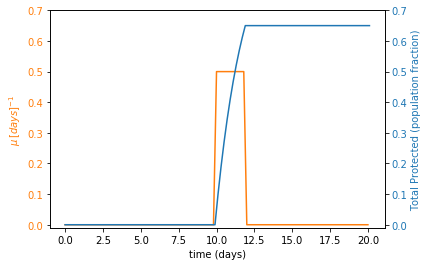

In [688]:
# plot combination

fig_e, ax1 = plt.subplots()

color = "tab:orange"
ax1.set_xlabel('time (days)')
ax1.set_ylabel('$\\mu  \, [days]^{-1}$', color=color)
ax1.plot(mock_time, mu_5, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ylim(-0.01,0.7)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Total Protected (population fraction)', color=color)  # we already handled the x-label with ax1
ax2.plot(t[:stop_plot_hard_ld], results_lockdown_3.T[4,:stop_plot_hard_ld], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ylim(-0.01,0.7)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


fig_e.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/plots_covid/mu_hard_lockdown.png",bbox_inches = "tight",transparent=True)

# Synergies
Let's look at some synergistic approach that does not involve extremes, but yields suppression.    
From the formula in the manuscript I know how to get R<1 by tuning parameters. Let us simulate a few settings.   
Some settings on Quad. 2.1, 14/04/2020

In [717]:
# synergies


def synergies_seir_model(init_vals, params, t):    
    S_0, E_0, I_0, R_0, P_0, Q_0 = init_vals
    S, E, I, R, P, Q = [S_0], [E_0], [I_0], [R_0], [P_0], [Q_0]
    alpha, beta, gamma, mu, mu_ld, rho, chi = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        
        if len(E)<100:
            next_S = S[-1] - (beta*S[-1]*I[-1])*dt       
            next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
            next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
            next_P = P[-1]
            next_Q = Q[-1]
        elif len(E)>=100 and len(E)<120:                  # two days 
            next_S = S[-1] - (beta*S[-1]*I[-1] + mu_ld*S[-1])*dt
            next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
            next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
            next_P = P[-1] + (mu_ld*S[-1])*dt
            next_Q = Q[-1]
        elif len(E)>=120: 
            next_S = S[-1] - (rho*beta*S[-1]*I[-1] + mu*S[-1])*dt
            next_E = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1] - chi*0.33*E[-1])*dt  #3 days to get reliable results from PCR
            next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
            next_Q = Q[-1] + (chi*0.33*E[-1])*dt
            next_P = P[-1] + (mu*S[-1])*dt
                           
        next_R = R[-1] + (gamma*I[-1])*dt
        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        P.append(next_P)
        Q.append(next_Q)
    return np.stack([S, E, I, R, P, Q]).T


In [752]:
# Define parameters
t_max = 1000
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0 ,0    #working with fractions of population
alpha = 0.2     # incubation period 5 days
beta = 0.85     # average contact rate [beta = R0*gamma; R0 = 2.5 (Hellewell, 2020)]
gamma = 0.34    # mean infectious period = 2.9 (Kucharski,2020)
mu =    [0.008, 0.01, 0.004, 0,   0.002, 0    ]       # removal rate
mu_ld = [0.2,   0.06, 0.1,   0.6, 0.2,   0.2  ]   # removal rate for hard lockdown
rho =   [0.7,   0.8,  0.45,   1,   0.7,   0.6  ]   # social distancing tuning
chi =   [0.15,  0.5,  0.1,   0.3, 0.1 , 0.2   ]   # latents' removal (e.g. contact tracing)

In [753]:
# run synergic sims

params_synergy1 = alpha, beta, gamma, mu[0], mu_ld[0], rho[0], chi[0]
params_synergy2 = alpha, beta, gamma, mu[1], mu_ld[1], rho[1], chi[1]
params_synergy3 = alpha, beta, gamma, mu[2], mu_ld[2], rho[2], chi[2]
params_synergy4 = alpha, beta, gamma, mu[3], mu_ld[3], rho[3], chi[3]
params_synergy5 = alpha, beta, gamma, mu[4], mu_ld[4], rho[4], chi[4]
params_synergy6 = alpha, beta, gamma, mu[5], mu_ld[5], rho[5], chi[5]


results_synergy1 = synergies_seir_model(init_vals, params_synergy1, t)
results_synergy2 = synergies_seir_model(init_vals, params_synergy2, t)
results_synergy3 = synergies_seir_model(init_vals, params_synergy3, t)
results_synergy4 = synergies_seir_model(init_vals, params_synergy4, t)
results_synergy5 = synergies_seir_model(init_vals, params_synergy5, t)
results_synergy6 = synergies_seir_model(init_vals, params_synergy6, t)

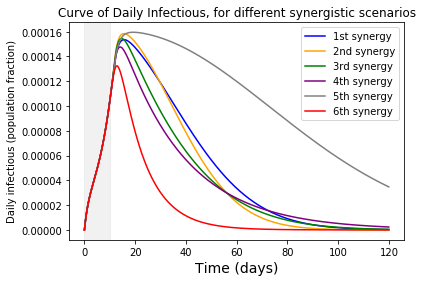

In [754]:
# plot infectious evolution

stop_plot_synergy = 1200

f, ax = plt.subplots(nrows=1, ncols=1)

plot(t[:stop_plot_synergy],results_synergy1.T[2,:stop_plot_synergy],"blue",label="1st synergy")
plot(t[:stop_plot_synergy],results_synergy2.T[2,:stop_plot_synergy],"orange",label="2nd synergy")
plot(t[:stop_plot_synergy],results_synergy3.T[2,:stop_plot_synergy],"green",label="3rd synergy")
plot(t[:stop_plot_synergy],results_synergy6.T[2,:stop_plot_synergy],"purple",label="4th synergy")
plot(t[:stop_plot_synergy],results_synergy5.T[2,:stop_plot_synergy],"gray",label="5th synergy")
plot(t[:stop_plot_synergy],results_synergy4.T[2,:stop_plot_synergy],"red",label="6th synergy")
# NB: 4 and 6 are swapped to be consistent with text



plt.title("Curve of Daily Infectious, for different synergistic scenarios")
xlabel("Time (days)", fontsize=14)
plt.legend()
ax.axvspan(0, 10, alpha=0.3, color='lightgrey')

ylabel("Daily infectious (population fraction)")

f.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/plots_covid/synergies_daily.png",bbox_inches = "tight",transparent=True)


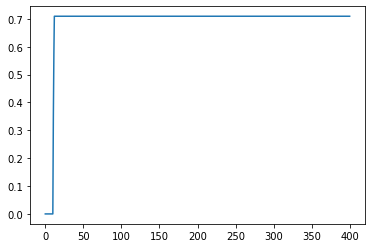

In [755]:
plot(t[:4000],results_synergy4.T[4,:4000])

In [756]:
sum1 = cumsum(results_synergy1.T[2])*gamma*dt
sum2 = cumsum(results_synergy2.T[2])*gamma*dt
sum3 = cumsum(results_synergy3.T[2])*gamma*dt
sum4 = cumsum(results_synergy4.T[2])*gamma*dt
sum5 = cumsum(results_synergy5.T[2])*gamma*dt
sum6 = cumsum(results_synergy6.T[2])*gamma*dt

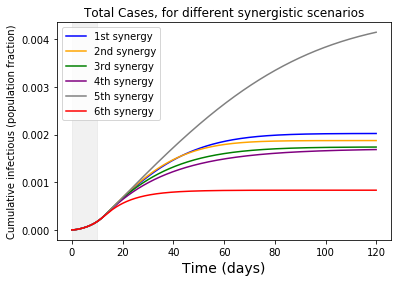

In [757]:
# plot infectious evolution

stop_plot_synergy = 1200

g, ax = plt.subplots(nrows=1, ncols=1)

plot(t[:stop_plot_synergy],sum1[:stop_plot_synergy],"blue",label="1st synergy")
plot(t[:stop_plot_synergy],sum2[:stop_plot_synergy],"orange",label="2nd synergy")
plot(t[:stop_plot_synergy],sum3[:stop_plot_synergy],"green",label="3rd synergy")
plot(t[:stop_plot_synergy],sum6[:stop_plot_synergy],"purple",label="4th synergy")
plot(t[:stop_plot_synergy],sum5[:stop_plot_synergy],"gray",label="5th synergy")
plot(t[:stop_plot_synergy],sum4[:stop_plot_synergy],"red",label="6th synergy")



plt.title("Total Cases, for different synergistic scenarios")
xlabel("Time (days)", fontsize=14)
plt.legend()
ax.axvspan(0, 10, alpha=0.3, color='lightgrey')

ylabel("Cumulative infectious (population fraction)")

g.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/plots_covid/synergies_cumulative.png",bbox_inches = "tight",transparent=True)


In [758]:
0.004*800000

3200.0

### Getting corresponding R

In [759]:
R = []

for i in range(6):
    R.append( 2.5*rho[i]*((1-mu[i])**30)*((1-mu_ld[i])**2)*(alpha/(alpha+0.33*chi[i])) )
    
print (R)

#remember that 4th and 6th are swapped

[0.7055497348712269, 0.716273150603709, 0.6935723459651557, 0.26755852842809363, 0.9053329686115509, 0.7218045112781956]
